In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor,cv,Pool
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/janta hack/train_file.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/janta hack/test_file.csv')

In [42]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [43]:
test.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A


In [44]:
#Check the number of unique values in the dataset
train.nunique()

ID                         26496
datetime                   26496
temperature                   60
var1                          71
pressure                      73
windspeed                   5603
var2                           3
electricity_consumption      252
dtype: int64

In [45]:
#Impute the values of 'electricity_consumption' column in test column as 0
test['electricity_consumption'] = 0

In [46]:
train['datetime'] = pd.to_datetime(train['datetime'],format='%Y-%m-%d %H:%M')
test['datetime'] = pd.to_datetime(test['datetime'],format='%Y-%m-%d %H:%M')

In [47]:
df = pd.merge(train,test,on=['ID','datetime','temperature','var1','pressure','windspeed','var2','electricity_consumption'],how='outer')
df.sort_values(by='datetime',inplace=True)
df.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [48]:
#Scaling the values of pressure and windspeed
df.fillna(0,inplace=True)
scaler = StandardScaler()
df['pressure'] = scaler.fit_transform(df['pressure'].values.reshape(-1,1))
df['windspeed'] = scaler.fit_transform(df['windspeed'].values.reshape(-1,1))

In [51]:
#Extracting date and time values from datetimr column
df['hour'] = df.datetime.dt.hour
df['day'] = df.datetime.dt.day
df['month'] = df.datetime.dt.month
df['year'] = df.datetime.dt.year
df['quarter'] = df.datetime.dt.quarter
df['day_of_week'] = df.datetime.dt.weekday
df['weekend'] = np.where(df['day_of_week'].isin([5,6]),1,0)
df['weekday'] = np.where(df['day_of_week'].isin([0,1,2,3,4]),1,0)

In [53]:
df.drop('ID',axis=1,inplace=True)
df.set_index('datetime',inplace=True)
df.head()

,temperature,var1,pressure,windspeed,var2,electricity_consumption,hour,day,month,year,quarter,day_of_week,weekend,weekday
datetime,,,,,,,,,,,,,,
2013-07-01 00:00:00,-11.4,-17.1,1.377193,11.269515,A,216.0,0,1,7,2013,3,0,0,1
2013-07-01 01:00:00,-12.1,-19.3,0.795712,11.333895,A,210.0,1,1,7,2013,3,0,0,1
2013-07-01 02:00:00,-12.9,-20.0,1.127987,11.403726,A,225.0,2,1,7,2013,3,0,0,1
2013-07-01 03:00:00,-11.4,-17.1,0.712643,11.488983,A,216.0,3,1,7,2013,3,0,0,1
2013-07-01 04:00:00,-11.4,-19.3,1.543331,11.571669,A,222.0,4,1,7,2013,3,0,0,1


In [54]:
plt.rcParams['figure.figsize'] = 12,6

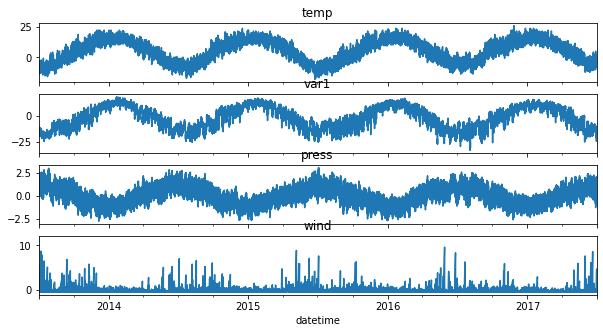

In [55]:
#Visualising the variation of temperature, var1, pressure and wind variables
fig,axs = plt.subplots(4,1,sharex=True)
df['temperature'].plot(figsize=(10,5),title='temp',ax=axs[0])
df['var1'].plot(figsize=(10,5),title='var1',ax=axs[1])
df['pressure'].plot(figsize=(10,5),title='press',ax=axs[2])
df['windspeed'].plot(figsize=(10,5),title='wind',ax=axs[3])
plt.show()

#### Feature Engineering

In [56]:
for i in ['temperature','pressure','var1']:
  df[f'cosine_{i}'] = df[i].apply(lambda x: np.cos(x))
  df[f'sine_{i}'] = df[i].apply(lambda x: np.sin(x))

In [57]:
def feature_gen(data):
  for i in ['day','month','year']:
    group = data[['temperature','var1','pressure','windspeed','electricity_consumption',i]].groupby(i).agg(['mean','min','max','std'])
    group.columns = ['_'.join(x)+f'_{i}' for x in group.columns.ravel()]
    data = pd.merge(data,group,on=i,how='left')
  return data

In [58]:
df = feature_gen(df)

df['log_wind'] = np.log1p(df['windspeed'])

group = df[['temperature','var1','pressure','windspeed','var2','day','month','year']].groupby('var2').agg({
    'temperature':['mean','min','max','std'],
    'var1':['mean','min','max','std'],
    'pressure':['mean','min','max','std'],
    'windspeed':['mean','min','max','std'],
    'day':['count'],
    'month':['count'],
    'year':['count']})
group.columns = ['_'.join(x)+'_var2' for x in group.columns.ravel()]
df = pd.merge(df,group,on='var2',how='left')

df['temp_diff_var1'] = abs(df['temperature']) - abs(df['var1'])
df.head()

,temperature,var1,pressure,windspeed,var2,electricity_consumption,hour,day,month,year,quarter,day_of_week,weekend,weekday,cosine_temperature,sine_temperature,cosine_pressure,sine_pressure,cosine_var1,sine_var1,temperature_mean_day,temperature_min_day,temperature_max_day,temperature_std_day,var1_mean_day,var1_min_day,var1_max_day,var1_std_day,pressure_mean_day,pressure_min_day,pressure_max_day,pressure_std_day,windspeed_mean_day,windspeed_min_day,windspeed_max_day,windspeed_std_day,electricity_consumption_mean_day,electricity_consumption_min_day,electricity_consumption_max_day,electricity_consumption_std_day,...,temperature_min_year,temperature_max_year,temperature_std_year,var1_mean_year,var1_min_year,var1_max_year,var1_std_year,pressure_mean_year,pressure_min_year,pressure_max_year,pressure_std_year,windspeed_mean_year,windspeed_min_year,windspeed_max_year,windspeed_std_year,electricity_consumption_mean_year,electricity_consumption_min_year,electricity_consumption_max_year,electricity_consumption_std_year,log_wind,temperature_mean_var2,temperature_min_var2,temperature_max_var2,temperature_std_var2,var1_mean_var2,var1_min_var2,var1_max_var2,var1_std_var2,pressure_mean_var2,pressure_min_var2,pressure_max_var2,pressure_std_var2,windspeed_mean_var2,windspeed_min_var2,windspeed_max_var2,windspeed_std_var2,day_count_var2,month_count_var2,year_count_var2,temp_diff_var1
0,-11.4,-17.1,1.377193,11.269515,A,216.0,0,1,7,2013,3,0,0,1,0.393491,0.919329,0.192396,0.981317,-0.177809,0.984065,5.187674,-15.7,22.9,8.753455,-2.207031,-25.7,15.7,10.578388,0.017736,-2.610107,2.540156,0.964377,-0.039746,-0.471801,11.571669,1.082697,287.28125,174.0,771.0,91.772974,...,-15.7,22.1,8.76983,-5.615104,-24.3,15.7,9.759862,0.051385,-2.776245,3.038568,1.087068,0.298098,-0.471801,11.571669,1.363749,221.545516,0.0,897.0,160.60273,2.507118,5.020706,-17.9,25.7,8.722338,-2.240777,-32.9,18.6,10.399023,0.016175,-2.776245,3.121637,0.999753,0.007337,-0.471801,11.571669,1.017406,33416,33416,33416,-5.7
1,-12.1,-19.3,0.795712,11.333895,A,210.0,1,1,7,2013,3,0,0,1,0.893206,0.449647,0.699776,0.714362,0.900254,-0.435365,5.187674,-15.7,22.9,8.753455,-2.207031,-25.7,15.7,10.578388,0.017736,-2.610107,2.540156,0.964377,-0.039746,-0.471801,11.571669,1.082697,287.28125,174.0,771.0,91.772974,...,-15.7,22.1,8.76983,-5.615104,-24.3,15.7,9.759862,0.051385,-2.776245,3.038568,1.087068,0.298098,-0.471801,11.571669,1.363749,221.545516,0.0,897.0,160.60273,2.512351,5.020706,-17.9,25.7,8.722338,-2.240777,-32.9,18.6,10.399023,0.016175,-2.776245,3.121637,0.999753,0.007337,-0.471801,11.571669,1.017406,33416,33416,33416,-7.2
2,-12.9,-20.0,1.127987,11.403726,A,225.0,2,1,7,2013,3,0,0,1,0.944860,-0.327474,0.428480,0.903551,0.408082,-0.912945,5.187674,-15.7,22.9,8.753455,-2.207031,-25.7,15.7,10.578388,0.017736,-2.610107,2.540156,0.964377,-0.039746,-0.471801,11.571669,1.082697,287.28125,174.0,771.0,91.772974,...,-15.7,22.1,8.76983,-5.615104,-24.3,15.7,9.759862,0.051385,-2.776245,3.038568,1.087068,0.298098,-0.471801,11.571669,1.363749,221.545516,0.0,897.0,160.60273,2.517997,5.020706,-17.9,25.7,8.722338,-2.240777,-32.9,18.6,10.399023,0.016175,-2.776245,3.121637,0.999753,0.007337,-0.471801,11.571669,1.017406,33416,33416,33416,-7.1
3,-11.4,-17.1,0.712643,11.488983,A,216.0,3,1,7,2013,3,0,0,1,0.393491,0.919329,0.756636,0.653836,-0.177809,0.984065,5.187674,-15.7,22.9,8.753455,-2.207031,-25.7,15.7,10.578388,0.017736,-2.610107,2.540156,0.964377,-0.039746,-0.471801,11.571669,1.082697,287.28125,174.0,771.0,91.772974,...,-15.7,22.1,8.76983,-5.615104,-24.3,15.7,9.759862,0.051385,-2.776245,3.038568,1.087068,0.298098,-0.471801,11.571669,1.363749,221.545516,0.0,897.0,160.60273,2.524847,5.020706,-17.9,25.7,8.722338,-2.240777,-32.9,18.6,10.399023,0.016175,-2.776245,3.121637,0.999753,0.007337,-0.471801,11.571669,1.017406,33416,33416,33416,-5.7
4,-11.4,-19.3,1.543331,11.571669,A,222.0,4,1,7,2013,3,0,0,1,0.393491,0.919329,0.027462,0.999623,0.900254,-0.435365,5.187674,-15.7,22.9,8.753455,-2.207031,-25.7,15.7,10.578388,0.

In [59]:
#Encoding the year and var2 variables
le = LabelEncoder()
df['var2'] = le.fit_transform(df['var2'])
df['year'] = le.fit_transform(df['year'])

In [60]:
X = df[df['electricity_consumption'] > 0]
X_valid = df[df['electricity_consumption'] == 0]

#### Model Training

In [61]:
#XGBRegressor model
xgbr2 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=3534,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 objective='reg:squarederror')
model_xgbr2 = xgbr2.fit(X.drop(['electricity_consumption'],axis=1),X['electricity_consumption'])
y_pred_xgbr2 = xgbr2.predict(X_valid.drop(['electricity_consumption'],axis=1))

In [62]:
test_res = test[['ID']]
test_res = pd.concat([test_res,pd.DataFrame(y_pred_xgbr2,columns=['electricity_consumption'])],axis=1)
test_res.set_index('ID',inplace=True)
test_res.to_csv('/content/drive/My Drive/Colab Notebooks/janta hack/sub_xgbr2.csv')

In [ ]:
#CatBoost model
ctr = CatBoostRegressor(iterations=5000,learning_rate=0.1,depth=5,loss_function='RMSE',od_wait=100,od_type='Iter')
cat_feat = np.where(X.drop(['electricity_consumption'],axis=1).dtypes != np.float)[0]
cv = cv(pool=Pool(X.drop(['electricity_consumption'],axis=1),X['electricity_consumption'],cat_features=cat_feat),params=ctr.get_params(),nfold=5,plot=True)

In [ ]:
model_ctr = ctr.fit(X.drop(['electricity_consumption'],axis=1),X['electricity_consumption'])
y_pred_ctr = ctr.predict(X_valid.drop(['electricity_consumption'],axis=1))
test_res_ctr = test[['ID']]
test_res_ctr = pd.concat([test_res_ctr,pd.DataFrame(y_pred_ctr,columns=['electricity_consumption'])],axis=1)
test_res_ctr.set_index('ID',inplace=True)
test_res_ctr.to_csv('/content/drive/My Drive/Colab Notebooks/janta hack/sub_ctr.csv')

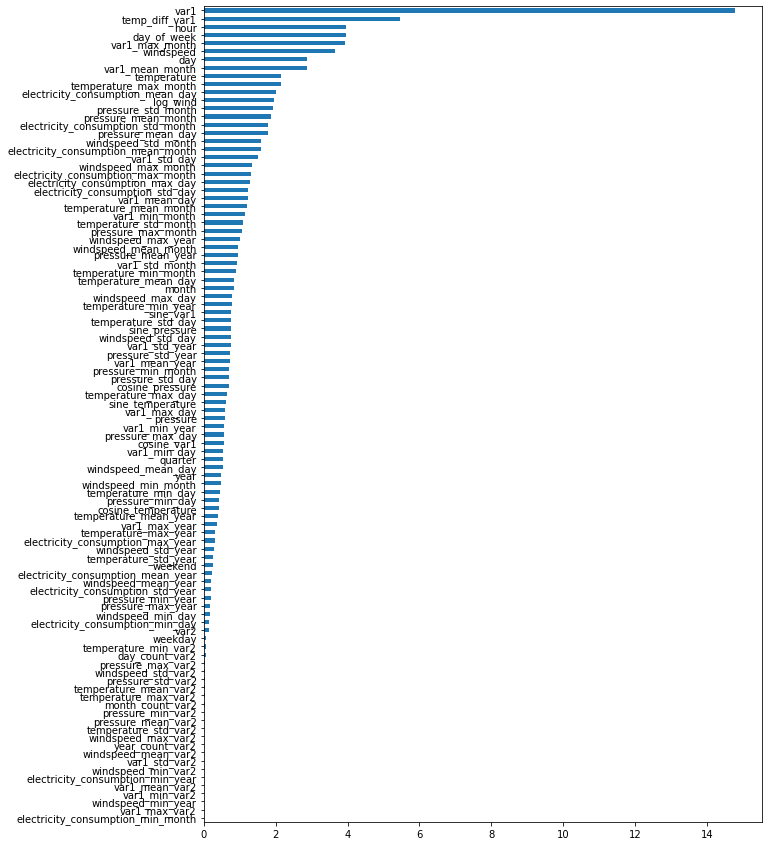

In [65]:
importance = ctr.feature_importances_
fi = pd.Series(index = X.drop(['electricity_consumption'],axis=1).columns, data = importance)
fi.sort_values(ascending=False)[0::][::-1].plot(kind = 'barh',figsize=(10,15))

In [ ]:
#LightGBM model
params = {'num_leaves':31,'max_depth':5,'learning_rate':0.1,'n_estimators':5000,'metric':'mse'}
lgbr1 = lgb.LGBMRegressor(num_leaves=31,max_depth=5,learning_rate=0.1,n_estimators=4000,random_state=27,metric='mse')
cat_feat = np.where(X.drop(['electricity_consumption'],axis=1).dtypes != np.float)[0]
dtrain = lgb.Dataset(X.drop(['electricity_consumption'],axis=1),label=X['electricity_consumption'])
cv_lgb = lgb.cv(params=params,train_set=dtrain,nfold=5,stratified=False,verbose_eval=True)

In [67]:
lgbr1 = lgb.LGBMRegressor(num_leaves=31,max_depth=5,learning_rate=0.1,n_estimators=4000,random_state=27,metric='mse')
model_lgbr1 = lgbr1.fit(X.drop(['electricity_consumption'],axis=1),X['electricity_consumption'])
y_pred_lgbr1 = lgbr1.predict(X_valid.drop(['electricity_consumption'],axis=1))
test_res_lgbr = test[['ID']]
test_res_lgbr = pd.concat([test_res_lgbr,pd.DataFrame(y_pred_lgbr1,columns=['electricity_consumption'])],axis=1)
test_res_lgbr.set_index('ID',inplace=True)
test_res_lgbr.to_csv('/content/drive/My Drive/Colab Notebooks/janta hack/sub_lgbr.csv')

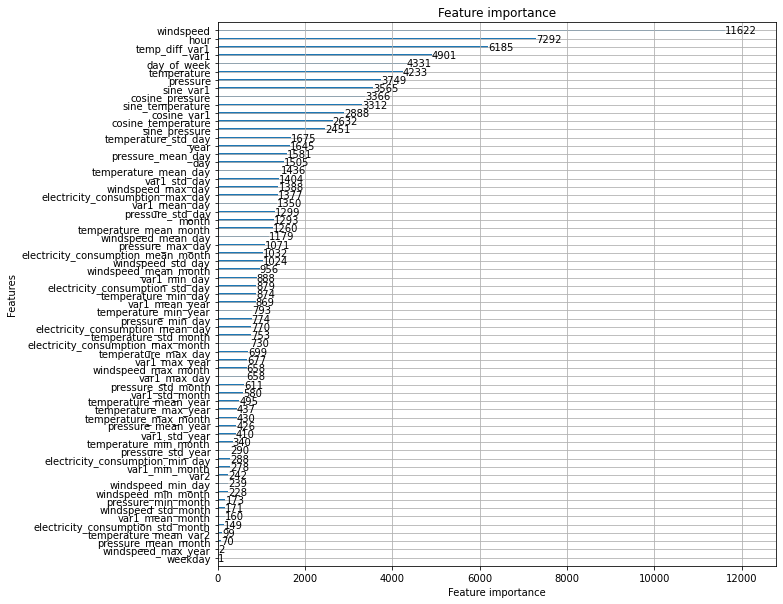

In [68]:
lgb.plot_importance(booster=lgbr1,figsize=(10,10))

We have added the features like quarter,weekday,weekend,dayofweek and mean,min,max,std of electricity consumption but these features have decreased the model score and lowered the rank on the leaderboard.

The Catboost model gave the best prediction score here.